### Variational Autoencoders


The encoding is somewhat obvious, transformation into another representation. Decoding inverses the encoding. The **autoencoder** is a Neural Network trained to perform encoding and decoding. It's generative because it can interpolate, in between existing data points.

In [3]:
from tensorflow.keras import datasets
import numpy as np
(x_train, y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

# we need to scale the pixel values (0-255) to (0-1) and pad (to go from 28x28 to 32x32)
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test  = preprocess(x_test)

An autoencoder neural network is comprised of two parts:
* An encoder that compresses high-demiensional data (like an image) into a lower-dimensional embedding vector.
* A decoder that decompresses the vecotr back to original domain.

The lower-dimensional represenation is often called **latent space**.

Let's start building the autoencoder, first **The Encoder**.


In [8]:
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
) 
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(2,name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

Going further? Experimenting with number of convolution layers and filters to understand
how the architecture affects the overall number of model parameters and performance.

In [11]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
) 
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
# adding an extra layer.
#x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(2,name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

### Decoder 
Time to build the decoder, which is the mirror image of the encoder.... 

In [12]:
decoder_input = layers.Input(shape=(2,), name="decoder_input") 
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) 
x = layers.Reshape(shape_before_flattening)(x) 
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x) 
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output) 
decoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [29]:
# Join the encoder and decoder to create the autoencoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_5 (Functional)        (None, 32, 32, 1)         2462

In [30]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2515INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 27s 44ms/step - loss: 0.2515 - val_loss: 0.2523
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2503INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 28s 47ms/step - loss: 0.2503 - val_loss: 0.2514
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2495INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 28s 47ms/step - loss: 0.2495 - val_loss: 0.2515


In [31]:
# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


In [32]:
# Reconstructing the images using the autoencoder
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [33]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 [==============================] - 1s 8ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[1.06349216e-05],
         [4.97028566e-07],
         [2.51777192e-06],
         ...,
         [1.19200912e-07],
         [4.15501603e-07],
         [7.98404144e-05]],

        [[3.78265838e-07],
         [2.81242691e-08],
         [4.61966323e-07],
         ...,
         [7.76713360e-09],
         [8.97114116e-09],
         [1.07747401e-05]],

        [[1.26310283e-07],
         [2.40926514e-08],
         [5.29923182e-06],
         ...,
         [5.78401455e-07],
         [1.36212236e-07],
         [1.26295217e-05]],

        ...,

        [[3.62669283e-10],
         [1.60325811e-12],
         [4.75166573e-10],
         ...,
         [4.62290678e-10],
         [8.38168701e-11],
         [2.93100602e-08]],

        [[1.53872435e-08],
         [9.07544387e-11],
         [1.72287784e-09],
         ...,
         [1.79655821e-11],
         [6.51885490e-11],
         [3.01508472e-08]],

        [[2.60280776e-05],
         [1.08488712e-06],
         [4.37836479e-06],
         ...,
 

### Visualizing the latent space


157/157 [==============================] - 0s 2ms/step
[[-3.7709136   2.161172  ]
 [ 0.5406979  -0.36133814]
 [10.992974    0.3060697 ]
 [ 9.806038    2.7142785 ]
 [ 0.27382624  0.31201363]
 [ 8.009597   -1.5114495 ]
 [ 1.8855704   1.9859399 ]
 [ 0.95451313  0.7879841 ]
 [-3.2238104   8.929411  ]
 [-3.60765     5.9510503 ]]


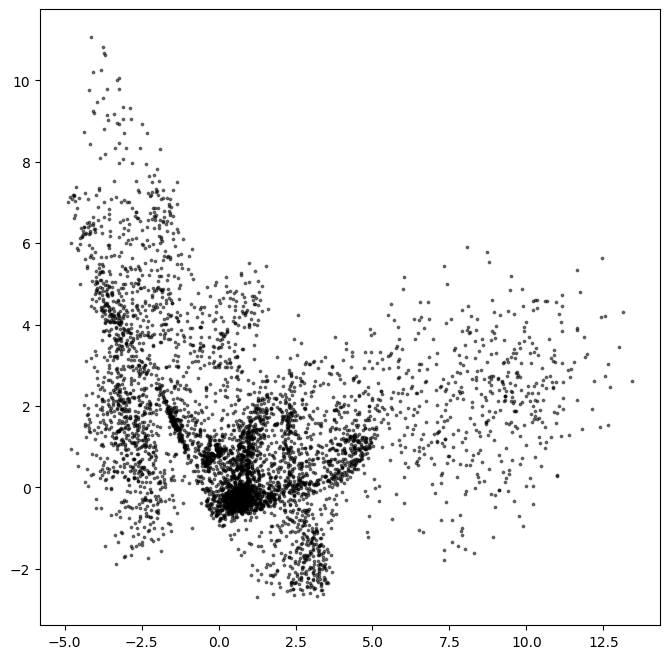

In [34]:
# Encode the example images
embeddings = encoder.predict(example_images)

import matplotlib.pyplot as plt

# Some examples of the embeddings
print(embeddings[:10])

# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

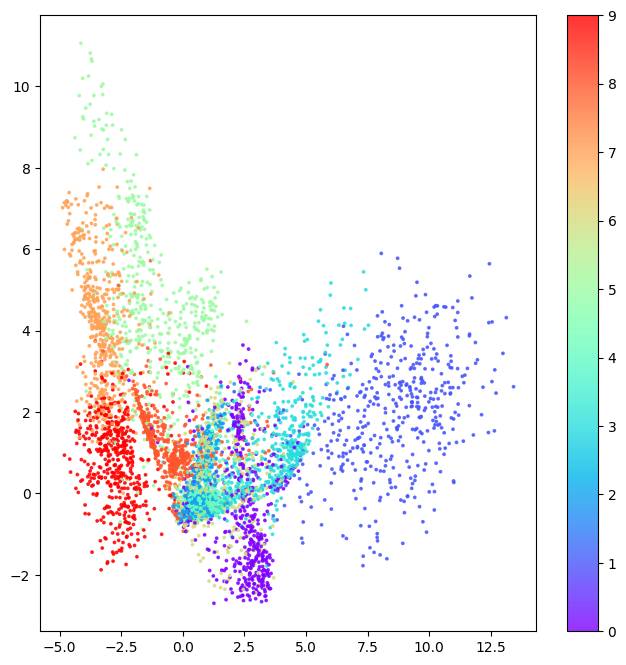

In [35]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

### Generate using the decoder


1/1 [==============================] - 0s 52ms/step


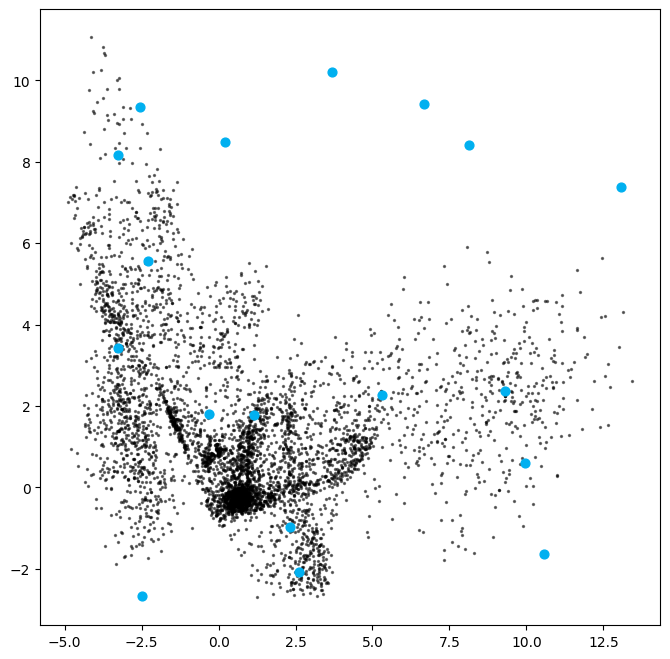

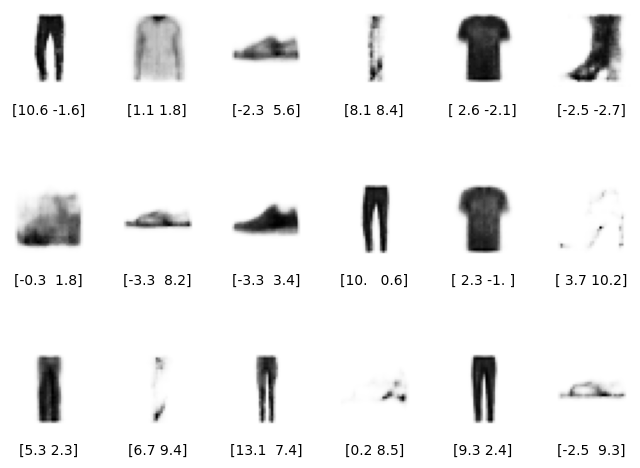

In [36]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

# Decode the sampled points
reconstructions = decoder.predict(sample)

# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 8ms/step


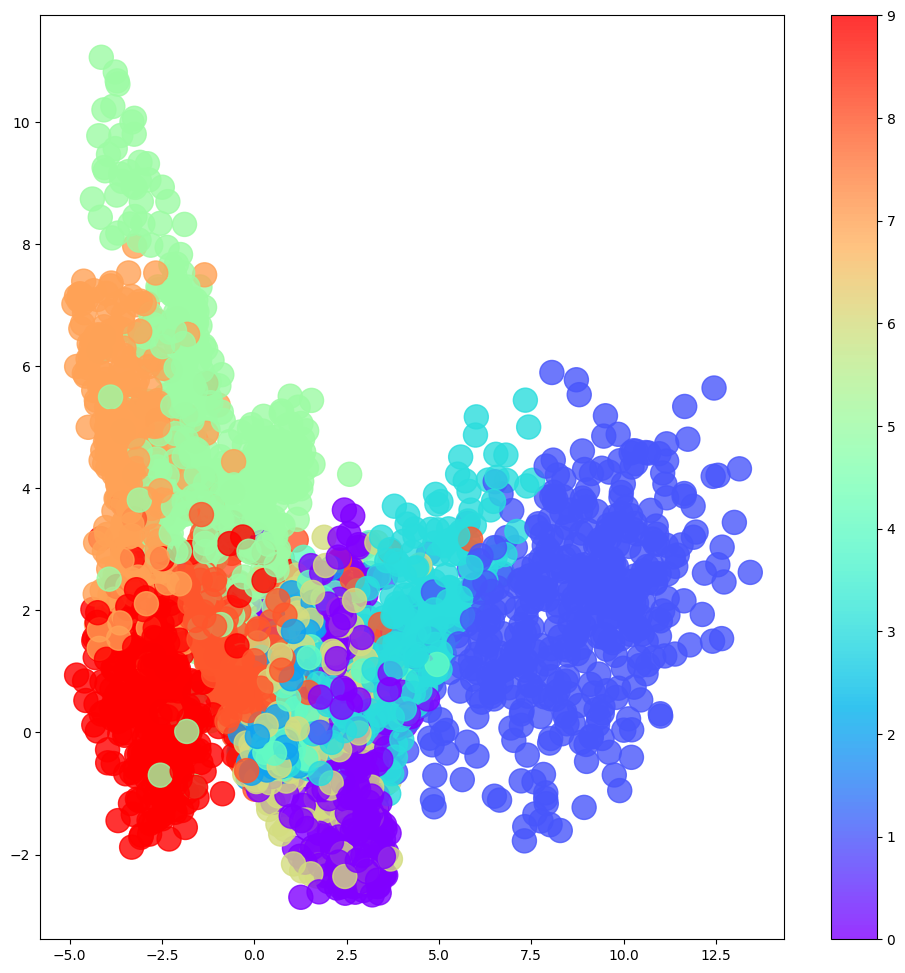

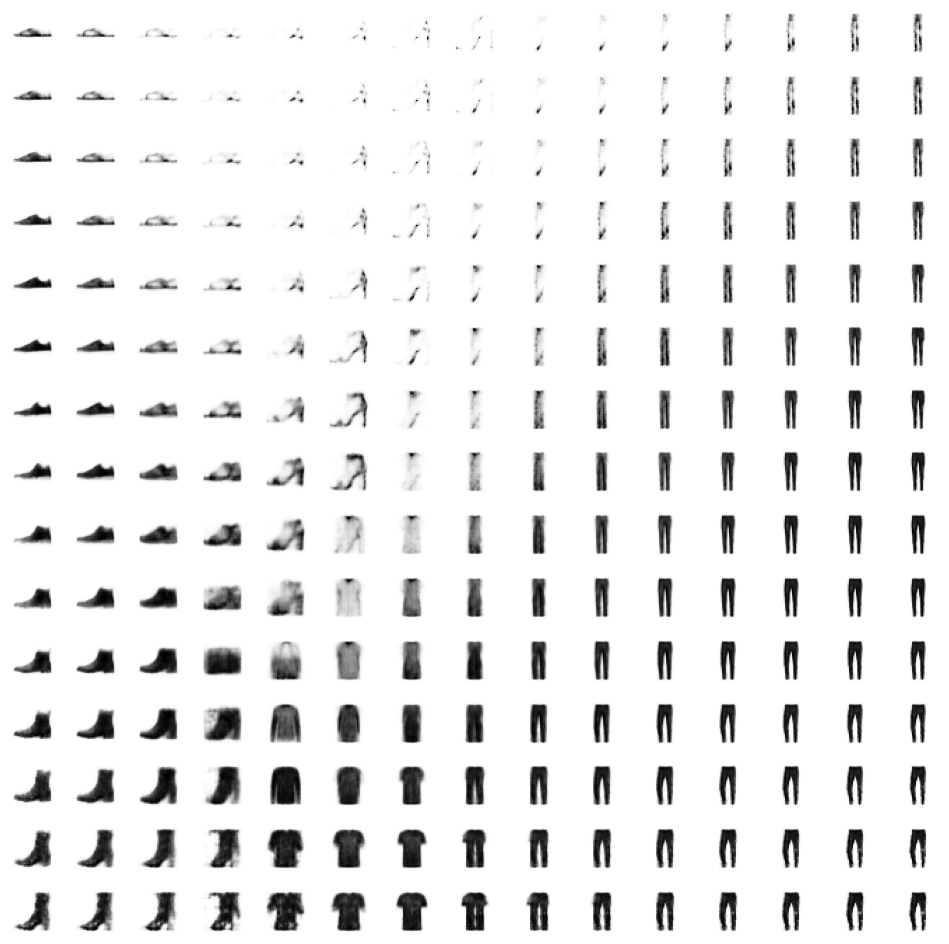

In [37]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")